In [1]:
from IPython.display import FileLink
%load_ext rpy2.ipython

In [2]:
%%R
library(dplyr)
library(ggplot2)
library(RColorBrewer)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
!wget -O ../data/tmp/core_set_aln.fasta \
http://greengenes.lbl.gov/Download/Sequence_Data/Fasta_data_files/core_set_aligned.fasta.imputed

--2014-11-19 15:33:38--  http://greengenes.lbl.gov/Download/Sequence_Data/Fasta_data_files/core_set_aligned.fasta.imputed
Resolving greengenes.lbl.gov (greengenes.lbl.gov)... 128.32.248.7
Connecting to greengenes.lbl.gov (greengenes.lbl.gov)|128.32.248.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37975992 (36M) [text/plain]
Saving to: `../data/tmp/core_set_aln.fasta'

100%[======================================>] 37,975,992  9.63M/s   in 5.3s    

2014-11-19 15:33:43 (6.83 MB/s) - `../data/tmp/core_set_aln.fasta' saved [37975992/37975992]



!wget -O ../data/tmp/lanemask.txt http://greengenes.lbl.gov/Download/Sequence_Data/lanemask_in_1s_and_0s

In [7]:
!align_seqs.py -p 0.50 -m pynast -i ../data/otusn.fasta -t ../data/tmp/core_set_aln.fasta -o ../data/tmp/otusn.core_set_aln

In [14]:
!filter_alignment.py -i ../data/tmp/otusn.core_set_aln/otusn_aligned.fasta \
-m ../data/tmp/lanemask.txt \
-g 1 \
-o ../data/tmp/aligned

In [15]:
!sed 's/[[:space:]][0-9]*\.\.[0-9]*//g' ../data/tmp/aligned/otusn_aligned_pfiltered.fasta \
> ../data/tmp/aligned/otusn.aligned.masked.fasta

In [13]:
!wget -O ../data/tmp/copy_number_est.zip http://s3-eu-west-1.amazonaws.com/files.figshare.com/295314/Dataset_S1.zip && \
unzip -o ../data/tmp/copy_number_est.zip -d ../data/tmp/ >/dev/null 2>&1

--2014-11-19 15:52:17--  http://s3-eu-west-1.amazonaws.com/files.figshare.com/295314/Dataset_S1.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 54.231.132.64
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|54.231.132.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223250 (218K) [application/zip]
Saving to: `../data/tmp/copy_number_est.zip'

100%[======================================>] 223,250      590K/s   in 0.4s    

2014-11-19 15:52:18 (590 KB/s) - `../data/tmp/copy_number_est.zip' saved [223250/223250]



In [22]:
refdir = "../data/tmp/copynum_estimation_scripts/refdir"
workdir = "../data/tmp"
!mkdir $workdir/pplacer
!pplacer \
-t $refdir/RAxML_result.reftree \
-r $refdir/reftree.alignment.fasta \
-s $refdir/RAxML_info.reftree \
--out-dir $workdir/pplacer \
$workdir/aligned/otusn.aligned.masked.fasta

Running pplacer v1.1.alpha16-2-gb964734 analysis on ../data/tmp/aligned/otusn.aligned.masked.fasta...
Didn't find any reference sequences in given alignment file. Using supplied reference alignment.
I'm going to try parsing as if this was version 7.2.3Pre-masking sequences... sequence length cut from 1287 to 221.
Determining figs... figs disabled.
Allocating memory for internal nodes... done.
Caching likelihood information on reference tree... done.
Pulling exponents... done.
Preparing the edges for baseball... done.
working on OTU.3877 (6236/6236)...


In [25]:
!guppy tog --out-dir $workdir/pplacer $workdir/pplacer/otusn.aligned.masked.jplace

In [30]:
!Rscript ../data/tmp/copynum_estimation_scripts/copynum_estimation.R $workdir $refdir otusn > $workdir/log.txt 2>&1

In [3]:
%%R
copynum.df = read.table("../data/tmp/copynum.est.csv", 
                        sep = ",", 
                        header = TRUE,
                        row.names = 1)
copynum.df$OTU = rownames(copynum.df)

In [4]:
%%R
l2fc.df = read.table("../data/l2fc_table.csv", 
                     sep = ",", 
                     header = TRUE)

In [46]:
%%R
colnames(copynum.df)

[1] "copynumber" "OTU"       


In [51]:
%%R
FDR = 0.10

d = left_join(l2fc.df, copynum.df)

d %>%
    filter(padj <= FDR, Treatment == "13CXPS", Day %in% c(1, 3, 7)) %>%
    group_by(Day) %>%
    summarize(copynum.med = median(copynumber),
              copynum.mean = mean(copynumber),
              copynum.sd = sd(copynumber))

Joining by: "OTU"
Source: local data frame [3 x 4]

  Day copynum.med copynum.mean copynum.sd
1   1    9.477252     9.606896   1.735063
2   3    5.213950     5.179625   2.143690
3   7    3.014205     3.734230   2.449944


Joining by: "OTU"
            Df Sum Sq Mean Sq F value   Pr(>F)    
factor(Day)  3  401.0  133.67   57.41 2.02e-15 ***
Residuals   45  104.8    2.33                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


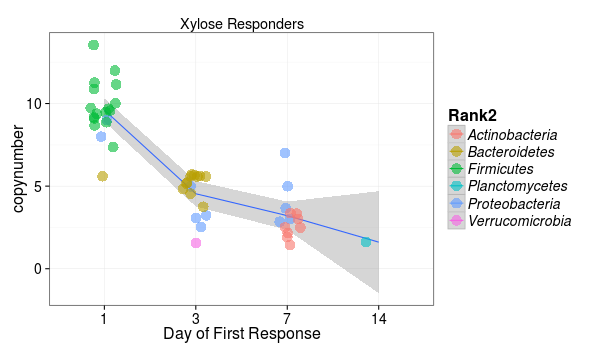

In [167]:
%%R -w 600 -h 350
FDR = 0.10

d = l2fc.df %>% 
    filter(padj <= FDR) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(Day = min(Day))

d = left_join(d, copynum.df) %>% filter(Treatment == "13CXPS")

p = ggplot(d, aes(x = factor(Day), y = copynumber, color = Rank2))

p = p + stat_smooth(aes(group = 1), method = "loess")

p = p + geom_point(size = 5, alpha = 0.60, position = position_jitter(w = 0.15))

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 16),
              legend.title = element_text(size = 16), 
              legend.text = element_text(size = 14, face = "italic"))

p = p + labs(x = "Day of First Response")

p = p + ggtitle("Xylose Responders")

print(summary(aov(copynumber ~ factor(Day), d)))

p.xyl = p

p.xyl

Joining by: "OTU"
            Df Sum Sq Mean Sq F value Pr(>F)
factor(Day)  3   5.40   1.799   1.327  0.274
Residuals   59  80.02   1.356               


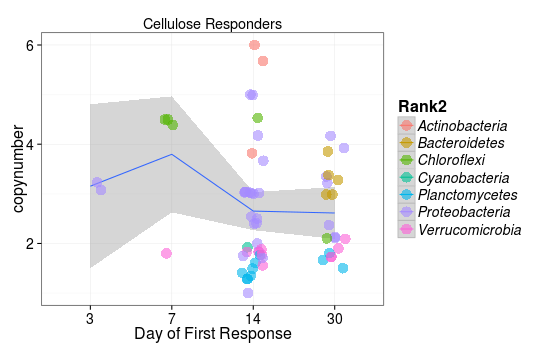

In [165]:
%%R -w 550 -h 350
FDR = 0.10

d = l2fc.df %>% 
    filter(padj <= FDR) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(Day = min(Day))

d = left_join(d, copynum.df) %>% filter(Treatment == "13CCPS")

p = ggplot(d, aes(x = factor(Day), y = copynumber, color = Rank2))

p = p + stat_smooth(aes(group = 1), method = "loess")

p = p + geom_point(size = 5, alpha = 0.60, position = position_jitter(w = 0.15))

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 16),
              legend.title = element_text(size = 16), 
              legend.text = element_text(size = 14, face = "italic"))

p = p + labs(x = "Day of First Response")

p = p + ggtitle("Cellulose Responders")

print(summary(aov(copynumber ~ factor(Day), d)))

p

Joining by: "OTU"


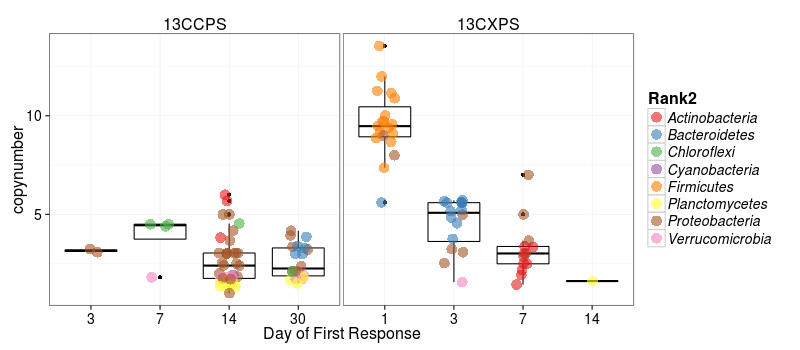

In [221]:
%%R -w 800 -h 350
FDR = 0.10

getPalette = colorRampPalette(brewer.pal(8, "Set1"))

d = l2fc.df %>% 
    filter(padj <= FDR) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(Day = min(Day))

d = left_join(d, copynum.df)

p = ggplot(d, aes(x = factor(Day), y = copynumber, color = Rank2))

p = p + facet_grid(.~Treatment, scales = "free_x", space = "free_x")

p = p + geom_boxplot(aes(group = Day), color = "black")

p = p + geom_point(size = 5, alpha = 0.60, position = position_jitter(w = 0.15))

p = p + scale_color_manual(values=getPalette(8))

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 16),
              legend.title = element_text(size = 16), 
              legend.text = element_text(size = 14, face = "italic"),
              strip.text = element_text(size = 16), 
              strip.background = element_blank())

p = p + labs(x = "Day of First Response")

p

In [222]:
%%R
ggsave("figs/day_facet_copy_number.pdf", p, h = 4, w = 9)

In [223]:
FileLink("figs/day_facet_copy_number.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/day_facet_copy_number.pdf

Joining by: "OTU"

	Wilcoxon rank sum test with continuity correction

data:  copynumber by Treatment
W = 538, p-value = 1.878e-09
alternative hypothesis: true location shift is less than 0



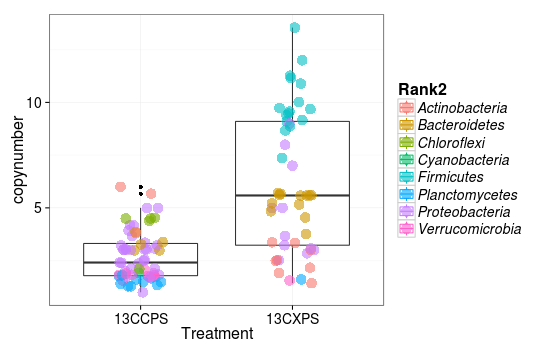

In [163]:
%%R -w 550 -h 350
FDR = 0.10

d = l2fc.df %>% 
    filter(padj <= FDR) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(Day = min(Day))

d = left_join(d, copynum.df)

p = ggplot(d, aes(x = Treatment, y = copynumber, color = Rank2))

p = p + geom_boxplot(aes(group = Treatment))

p = p + geom_point(size = 5, alpha = 0.60, position = position_jitter(w = 0.15))

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 16),
              legend.title = element_text(size = 16), 
              legend.text = element_text(size = 14, face = "italic"))

print(wilcox.test(copynumber ~ Treatment, d, alternative = "less"))

p

Joining by: "OTU"


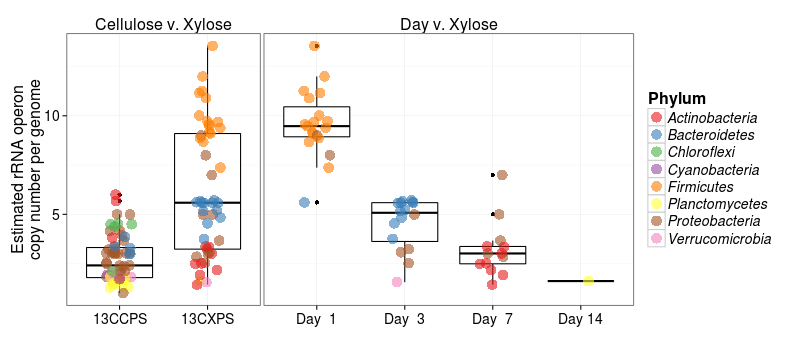

In [217]:
%%R -w 800 -h 350
d = l2fc.df %>% 
    filter(padj <= FDR) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(Day = min(Day))

d = left_join(d, copynum.df) 

d.xyl = d %>% filter(Treatment == "13CXPS")

d$x = d$Treatment
d$panel = "Cellulose v. Xylose"

d.xyl$x = factor(d.xyl$Day)
d.xyl$panel = "Day v. Xylose"

d.plot = rbind(d, d.xyl)
levels(d.plot$x) = c("13CCPS", "13CXPS", "Day  1", "Day  3", "Day  7", "Day 14")

getPalette = colorRampPalette(brewer.pal(8, "Set1"))

p = ggplot(d.plot, aes(x = x, y = copynumber, color = Rank2))

p = p + facet_grid(. ~ panel, scales = "free_x", space = "free_x")

p = p + geom_boxplot(aes(group = x), color = "black")

p = p + geom_point(size = 5, alpha = 0.60, position = position_jitter(w = 0.15))

p = p + scale_color_manual(values=getPalette(8))

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 16),
              legend.title = element_text(size = 16), 
              legend.text = element_text(size = 14, face = "italic"),
              strip.text = element_text(size = 16), 
              strip.background = element_blank())

p = p + labs(x = "", color = "Phylum", y = "Estimated rRNA operon\ncopy number per genome")

p

In [218]:
%%R
ggsave("figs/copy_number.pdf", p, h = 4, w = 9)

In [219]:
FileLink("figs/copy_number.pdf")

/home/chuck/working/CSIP_succession_data_analysis/figures_and_stats/figs/copy_number.pdf

In [225]:
%%R
write.table(copynum.df, "../data/copynum.df", row.names = FALSE, sep = ",")

In [226]:
!head ../data/copynum.df

"copynumber","OTU"
6.99914373694972,"OTU.3363"
3.00008474039554,"OTU.1625"
3.23162691063393,"OTU.6"
3.3375246264646,"OTU.6120"
2.00011918513427,"OTU.2782"
2.78313939713377,"OTU.5988"
2.81479912564016,"OTU.2445"
3.15214658200467,"OTU.3871"
3.72369573217076,"OTU.312"


In [7]:
%%R
FDR = 0.10

left_join(l2fc.df, copynum.df)%>%
    filter(padj <= FDR) %>%
    group_by(Treatment) %>%
    summarize(copynum.med = median(copynumber),
              copynum.mean = mean(copynumber),
              copynum.sd = sd(copynumber))

Joining by: "OTU"
Source: local data frame [2 x 4]

  Treatment copynum.med copynum.mean copynum.sd
1    13CCPS    2.403173     2.718184   1.197891
2    13CXPS    5.590373     6.163416   3.414517
